### **Aluna**: Lais de Souza Ziegler
# 📈 Predição de aprovação de Financiamento 
Dataset: [Loan Prediction](https://www.kaggle.com/datasets/sajidvali/loan-prediction/data)

O conjunto de dados de Loan Prediction contém informações sobre solicitantes de empréstimos, incluindo variáveis como gênero, estado civil, número de dependentes, educação, renda do solicitante, valor do empréstimo e status de crédito. Ele é utilizado para prever a probabilidade de aprovação de financiamento com base nas características dos solicitantes.
- Esse conjunto foi escolhido por sua relevância no mundo real, onde a análise de crédito é uma prática cotidiana. A variedade de variáveis, tanto categóricas quanto numéricas, oferece uma excelente oportunidade para explorar diferentes técnicas de pré-processamento e modelagem. Sinto que trabalhar com esses dados não só ajuda a desenvolver minhas habilidades em análise e aprendizado de máquina, mas também traz entendimento prático sobre decisões financeiras. É uma experiência que considero valiosa.

### 1️⃣ Leitura e exploração dos dados
---
#### Importando as bibliotecas necessárias para a análise de dados

In [21]:
# Pacotes básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pacotes do Scikit-learn para acesso a datasets, preparação, modelagem e avaliação
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Pacotes para modelos de aprendizado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier

# Pacote de balanceamento de classes desbalanceadas
from imblearn.over_sampling import SMOTE

#### Carregando o conjunto de dados a partir de um arquivo CSV 
- Em seguida, imprimindo os tipos de dados de cada coluna para entender a estrutura do DataFrame
- Exibindo as primeiras cinco linhas do conjunto de dados para uma visão geral dos dados


In [22]:
df = pd.read_csv("loan-prediction.csv")
print(df.dtypes)
df.head()

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


#### Imprimindo a forma do DataFrame, que retorna o número de linhas e colunas, 

In [23]:
print(df.shape)

(614, 13)


#### Análise de Distribuição
- A distribuições de ApplicantIncome, CoapplicantIncome e LoanAmount estão positivamente assimétricas
- Distribuições assimétricas positivas (ou enviesadas) têm uma cauda longa à direita, o que pode afetar a performance de alguns algoritmos de aprendizado de máquina.

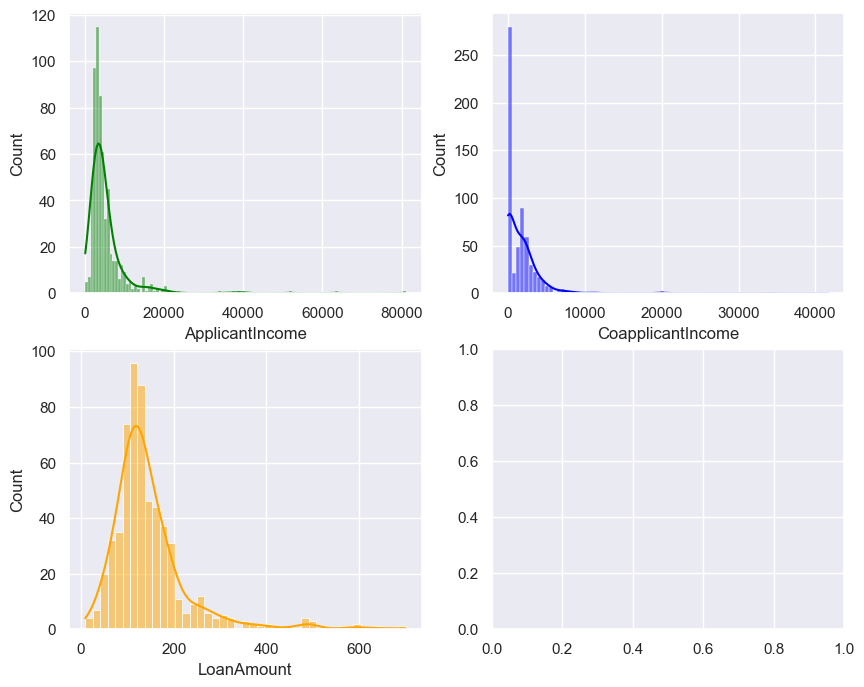

In [24]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

sns.histplot(data=df, x="ApplicantIncome", kde=True, ax=axs[0, 0], color='green')
sns.histplot(data=df, x="CoapplicantIncome", kde=True, ax=axs[0, 1], color='blue')
sns.histplot(data=df, x="LoanAmount", kde=True, ax=axs[1, 0], color='orange');

### 2️⃣ Pré-processamento de dados
---
#### Removendo a coluna 'Loan_ID' do DataFrame, pois ela não é relevante para a análise ou modelagem, 
- Utilizando o parâmetro 'axis=1' para indicar que a remoção é feita em colunas.

In [25]:
df = df.drop(['Loan_ID'], axis = 1)

#### Verificando a quantidade de valores ausentes em cada coluna do DataFrame, 
- Utilizando o método 'isnull().sum()' para identificar possíveis lacunas nos dados que precisam ser tratadas.

In [26]:
df.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

#### Preenchendo os valores ausentes nas colunas:
- 'Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History' e 'Loan_Amount_Term' com a moda (valor mais frequente) de cada coluna.
- Os valores ausentes na coluna 'LoanAmount' são preenchidos com a média da coluna, 
- Garante que a informação esteja disponível nessas variáveis para análise e modelagem, sem introduzir viés significativo.

In [27]:
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Married'] = df['Married'].fillna(df['Married'].mode()[0])
df['Dependents'] = df['Dependents'].fillna(df['Dependents'].mode()[0])
df['Self_Employed'] = df['Self_Employed'].fillna(df['Self_Employed'].mode()[0])
df['Credit_History'] = df['Credit_History'].fillna(df['Credit_History'].mode()[0])
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0])

df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].mean())

#### Transformando variáveis categóricas em variáveis dummy
- Criando colunas binárias para cada categoria
- Em seguida, convertendo todas as colunas do DataFrame para o tipo inteiro com 'astype(int)'

#### Removendo colunas desnecessárias que representam categorias redundantes 
- ex. 'Gender_Female', 'Married_No', 'Education_Not Graduate', 'Self_Employed_No', 'Loan_Status_N'

#### Renomeando colunas para simplificar os nomes e torná-los mais intuitivos
- Exibindo as primeiras linhas do DataFrame resultante para verificar as alterações

Esta técnica é conhecida como "One-hot Encoding". Ela é utilizada para transformar variáveis categóricas (que não possuem uma ordem numérica natural) em uma representação numérica que pode ser entendida por algoritmos de aprendizado de máquina. Isso é feito criando colunas binárias (0 ou 1) para cada possível valor da categoria.


In [28]:
df = pd.get_dummies(df)
df = df.astype(int)

df = df.drop(['Gender_Female', 'Married_No', 'Education_Not Graduate', 
              'Self_Employed_No', 'Loan_Status_N'], axis = 1)

new = {'Gender_Male': 'Gender', 'Married_Yes': 'Married', 
       'Education_Graduate': 'Education', 'Self_Employed_Yes': 'Self_Employed',
       'Loan_Status_Y': 'Loan_Status'}
       
df.rename(columns=new, inplace=True)

df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender,Married,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education,Self_Employed,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status
0,5849,0,146,360,1,1,0,1,0,0,0,1,0,0,0,1,1
1,4583,1508,128,360,1,1,1,0,1,0,0,1,0,1,0,0,0
2,3000,0,66,360,1,1,1,1,0,0,0,1,1,0,0,1,1
3,2583,2358,120,360,1,1,1,1,0,0,0,0,0,0,0,1,1
4,6000,0,141,360,1,1,0,1,0,0,0,1,0,0,0,1,1


#### Remoção de Outliers
- Calculando os quartis Q1 (25º percentil) e Q3 (75º percentil) das colunas numéricas do DataFrame para determinar o intervalo interquartil (IQR). 
- Em seguida, removendo as linhas do DataFrame que contêm outliers, definidos como valores que estão abaixo de (Q1 - 1.5 * IQR) ou acima de (Q3 + 1.5 * IQR)
- Isso garante que a análise e modelagem sejam realizadas com dados mais representativos e sem valores extremos que possam distorcer os resultados.


In [29]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

#### Transformação com raiz quadrada
- Aplicando a transformação de raiz quadrada nas colunas 'ApplicantIncome', 'CoapplicantIncome' e 'LoanAmount'
- Redução da assimetria e melhora da normalidade da distribuição dos dados. 
- Isso ajuda a atender melhor os pressupostos dos modelos estatísticos e de aprendizado de máquina.

In [30]:
df.ApplicantIncome = np.sqrt(df.ApplicantIncome)
df.CoapplicantIncome = np.sqrt(df.CoapplicantIncome)
df.LoanAmount = np.sqrt(df.LoanAmount)

#### Tratamento de Distribuições Assimétricas 📐
- A distribuição das variáveis 'ApplicantIncome', 'CoapplicantIncome' e 'LoanAmount' foi identificada como positivamente assimétrica. 
- Para normalizar essas distribuições, a transformação por raiz quadrada é uma técnica que pode ajudar a "achatar" a assimetria, tornando a distribuição mais simétrica e próxima de uma distribuição normal, o que facilita o trabalho dos modelos.
- Os histogramas mostram que, após a transformação, as distribuições estão muito mais próximas de uma forma normal em comparação com as distribuições originais.


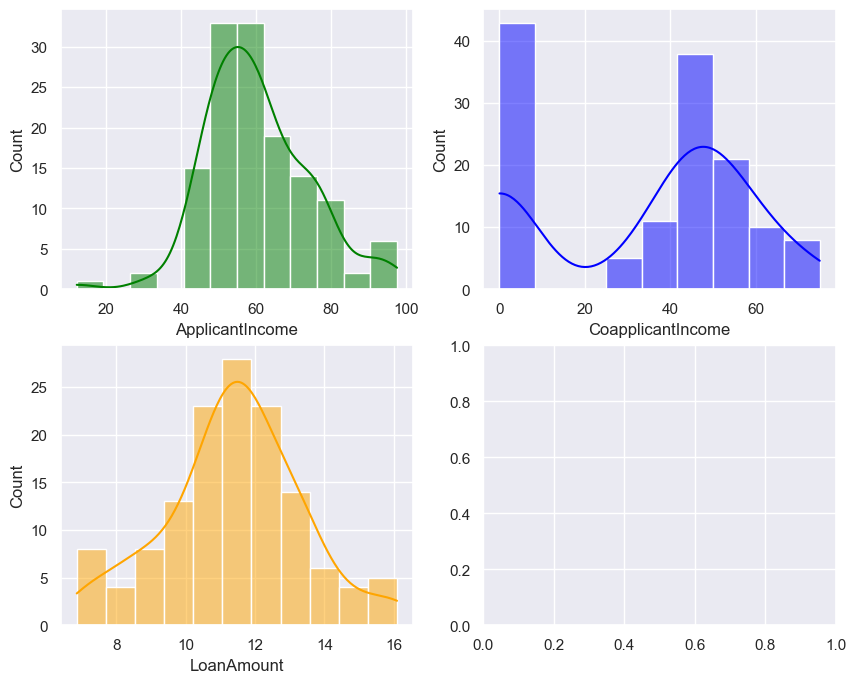

In [31]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

sns.histplot(data=df, x="ApplicantIncome", kde=True, ax=axs[0, 0], color='green')
sns.histplot(data=df, x="CoapplicantIncome", kde=True, ax=axs[0, 1], color='blue')
sns.histplot(data=df, x="LoanAmount", kde=True, ax=axs[1, 0], color='orange');

#### Separando os atributos do conjunto de dados em variáveis independentes (X) e a variável dependente (y).
- As variáveis independentes são todas as colunas do DataFrame, exceto 'Loan_Status', que é removida. 
- A variável dependente 'Loan_Status' é isolada em y, que indica o status do empréstimo.


In [32]:
X = df.drop(["Loan_Status"], axis=1)
y = df["Loan_Status"]

#### Aplicando o método SMOTE 
- Usado para aumentar a quantidade de amostras da classe minoritária nas variáveis independentes (X) e dependentes (y). 
- Essa técnica ajuda o modelo treinado a capturar melhor os padrões da classe minoritária, 
- Isso melhora a acurácia e a robustez das previsões.

In [33]:
X, y = SMOTE().fit_resample(X, y)

#### Criando um gráfico de contagem (countplot) 
- Visualização da distribuição do 'Loan_Status' com a contagem das classes na variável no eixo y. 
- Definindo os rótulos do eixo y como 'Loan Status' e do eixo x como 'Total'.


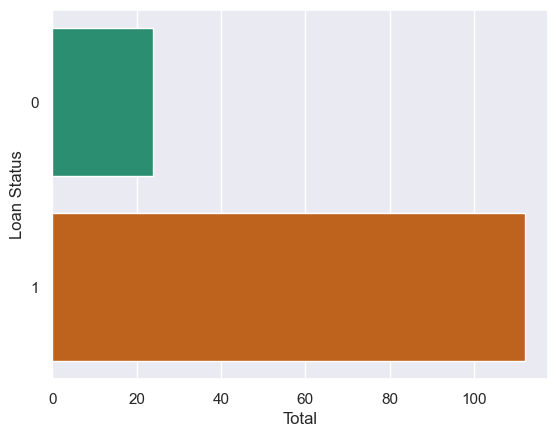

In [34]:
sns.set_theme(style="darkgrid")
sns.countplot(y='Loan_Status', data=df, hue='Loan_Status', palette="Dark2", legend=False)
plt.ylabel('Loan Status')
plt.xlabel('Total')
plt.show()

#### Dividindo o conjunto de dados em conjuntos de treinamento e teste
- O conjunto de teste representa 20% dos dados, enquanto 80% são usados para treinamento. 
- A divisão é feita de forma aleatória, mas com um estado fixo (random_state = 0) para garantir a reprodutibilidade dos resultados em execuções futuras.


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


### 3️⃣ Modelos
Três algoritmos de aprendizado de máquina serão utilizados: K-Nearest Neighbors (KNN), Naive Bayes e Árvore de Decisão. Eles serão aplicados para prever o status de empréstimo com base no conjunto de dados de financiamento. 
#### Avaliação da Precisão do Classificador KNN
- Inicialização de uma lista para armazenar as precisões do modelo KNN para diferentes valores de K.
- Execução de um loop de 1 a 20 para testar diferentes números de vizinhos (n_neighbors).
- Para cada valor de K, cria-se um classificador KNeighborsClassifier, treinando-o com o conjunto de treinamento e armazenando a precisão do modelo no conjunto de teste na lista 'scoreListknn'.
- Em seguida, plot da precisão do modelo em função do número de vizinhos (K) usando um gráfico de linha, com os valores de K no eixo x e a precisão no eixo y.
- O resultado é a melhor precisão alcançada pelo modelo KNN em formato percentual.


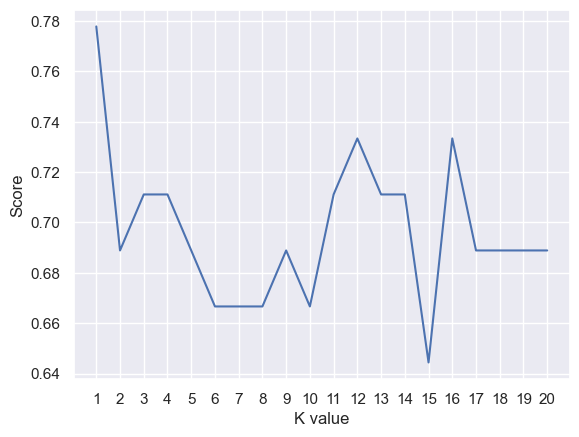

Melhor acurácia do algoritmo KNN: 77.78%


In [36]:
scoreListknn = []
for i in range(1,21):
    KNclassifier = KNeighborsClassifier(n_neighbors = i)
    KNclassifier.fit(X_train, y_train)
    scoreListknn.append(KNclassifier.score(X_test, y_test))
    
plt.plot(range(1,21), scoreListknn)
plt.xticks(np.arange(1,21,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()
KNAcc = max(scoreListknn)
print("Melhor acurácia do algoritmo KNN: {:.2f}%".format(KNAcc*100))

#### Avaliação do Classificador de Naive Bayes
- Treinando o classificador Naive Bayes com o conjunto de treinamento
- Realizando previsões no conjunto de teste e armazenando os resultados
- Imprimindo o relatório de classificação que inclui métricas como precisão, recall e F1-score para avaliar o desempenho do modelo em relação ao 'y_test'.
- Imprimindo a matriz de confusão para visualizar o desempenho do classificador em termos de verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos.
- Calculando e imprimindo a acurácia do classificador Naive Bayes em formato percentual, comparando as previsões ('y_pred') com os rótulos verdadeiros ('y_test').


In [37]:
NBclassifier1 = CategoricalNB()
NBclassifier1.fit(X_train, y_train)

y_pred = NBclassifier1.predict(X_test)

print(classification_report(y_test, y_pred))
print('Matriz de confusão: ')
print(confusion_matrix(y_test, y_pred))

NBAcc1 = accuracy_score(y_pred,y_test)
print('Acurácia do algoritmo de Naive Bayes: {:.2f}%'.format(NBAcc1*100))

              precision    recall  f1-score   support

           0       0.66      0.83      0.73        23
           1       0.75      0.55      0.63        22

    accuracy                           0.69        45
   macro avg       0.70      0.69      0.68        45
weighted avg       0.70      0.69      0.68        45

Matriz de confusão: 
[[19  4]
 [10 12]]
Acurácia do algoritmo de Naive Bayes: 68.89%


#### Avaliação do Classificador de Árvore de Decisão
- Inicializando uma lista para armazenar as precisões do modelo de Árvore de Decisão para diferentes números de folhas.
- Executando um loop de 2 a 20 para testar diferentes valores de 'max_leaf_nodes'.
- Para cada valor de 'max_leaf_nodes', criando um classificador DecisionTreeClassifier, treinando-o com o conjunto de treinamento e armazenando a precisão do modelo no conjunto de teste.
- Plotando a precisão do modelo em função do número de folhas usando um gráfico de linha, com os valores de folhas no eixo x e a precisão no eixo y.
- Ajustando os rótulos dos eixos e exibindo o gráfico resultante.
- Encontrando e imprimindo a melhor precisão alcançada pelo modelo de Árvore de Decisão em formato percentual.


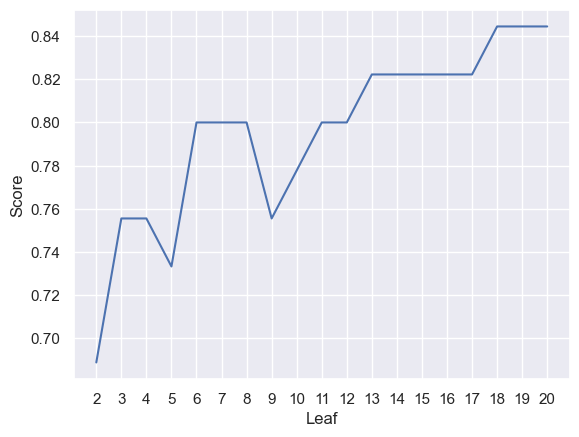

Acurácia do algoritmo de Árvore de Decisão: 84.44%


In [38]:
scoreListDT = []
for i in range(2,21):
    DTclassifier = DecisionTreeClassifier(max_leaf_nodes=i)
    DTclassifier.fit(X_train, y_train)
    scoreListDT.append(DTclassifier.score(X_test, y_test))
    
plt.plot(range(2,21), scoreListDT)
plt.xticks(np.arange(2,21,1))
plt.xlabel("Leaf")
plt.ylabel("Score")
plt.show()
DTAcc = max(scoreListDT)
print("Acurácia do algoritmo de Árvore de Decisão: {:.2f}%".format(DTAcc*100))

### 📊 Conclusões
O K Neighbors apresentou a maior acurácia, seguido pelo Decision Tree e, por último, Naive Bayes. Além disso, ao observar o F1-score, podemos perceber que o K Neighbors não apenas fornece uma alta acurácia, mas também equilibra a precisão e o recall, sendo mais robusto em relação a casos de classes desbalanceadas.

In [39]:
compare = pd.DataFrame({'Model': ['K Neighbors', 'Naive Bayes', 'Árvore de Decisão'], 
                        'Acurácia': [KNAcc*100, NBAcc1*100,DTAcc*100]})
compare.sort_values(by='Acurácia', ascending=False)

,Model,Acurácia
2,Árvore de Decisão,84.444444
0,K Neighbors,77.777778
1,Naive Bayes,68.888889


#### ⚖️ Qualidade da Predição vs. Custo de Treinamento
Em termos de custo de treinamento, o K Neighbors requer o armazenamento de todos os pontos de treinamento, o que pode ser custoso em termos de memória e tempo de previsão, especialmente com grandes conjuntos de dados. Por outro lado, o Decision Tree, embora possa apresentar um tempo de treinamento mais longo, resulta em um modelo mais simples e rápido na fase de predição. O Categorical Naive Bayes, por sua vez, é o mais leve em termos de custo de treinamento, mas pode não capturar a complexidade dos dados tão bem quanto os outros modelos, refletindo-se na sua acurácia inferior.

#### 🏆 Escolha do Melhor Algoritmo
Após a análise, o algoritmo K Neighbors foi escolhido como o mais adequado para esta tarefa de classificação. Sua alta acurácia e bom equilíbrio entre precisão e recall o tornam uma escolha robusta. Embora tenha um custo de treinamento mais elevado, os benefícios em termos de qualidade da predição justificam essa escolha. Além disso, sua capacidade de lidar com classes desbalanceadas e a facilidade de ajuste de hiperparâmetros permitem uma maior flexibilidade em cenários do mundo real.

Em resumo, a análise destaca a importância de considerar não apenas a acurácia, mas também o custo de treinamento e a complexidade do modelo ao selecionar o algoritmo mais apropriado para tarefas de classificação.